# PRO

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [3]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

In [4]:
def treinar_e_reportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(type(model).__name__)
        
        if(type(model).__name__ == 'XGBClassifier'):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
            
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        if(type(model).__name__ == 'XGBClassifier'):
            preds = enc.inverse_transform(preds.reshape(-1,1))
            y_test = enc.inverse_transform(y_test.reshape(-1, 1))
            y_train = enc.inverse_transform(y_train.reshape(-1, 1))
        
        print('\n', 70*"-"," Teste ",  70*"-", '\n',)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report_extendido(y_test, preds))
        
            
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        
        if(type(model).__name__ == 'XGBClassifier'):
            preds = enc.inverse_transform(preds.reshape(-1,1))
            
        print('\n', 70*"-"," Treino ",  70*"-", '\n',)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report_extendido(y_train, preds))
        print('\n', 150*"_", '\n',)

In [5]:
# Função para rodar GLM

def glm_treinar_e_reportar(df_train, df_test, method = 'bfgs'):
    from patsy import dmatrices
    import statsmodels.api as sm

    df_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]
    df_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]

    y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

    y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

    X_train, X_test = reescalar_dados(X_train, X_test)

    glm_model = sm.MNLogit(y_train, X_train) 

    glm_results = glm_model.fit(method=method)

    preds = glm_results.predict(X_test)

    preds[3] = preds.median(axis=1)

    preds = preds.reset_index(drop=True)

    b = np.zeros((preds.shape[0], 3))

    for i in range(preds.shape[0]):
        for j in range(3):
            if preds.loc[i,j] > preds.loc[i,3]:
                b[i,j] = 1
            else:
                b[i,j] = 0

    preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)

    # Reverso de get_dummies
    preds = preds.idxmax(axis=1)

    y_test = y_test.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

    y_test = y_test.idxmax(axis=1)
    
    y_test = y_test.reset_index(drop=True)
    
    print(classification_report_extendido(y_test, preds))

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    plt.show()

## Leave One Group Out

In [6]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
# Modelos PRO
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, 
                           colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, 
                                  criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", learning_rate="adaptive", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [8]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [9]:
df = pd.read_csv(caminho_dados_lazaro)

In [10]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [11]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [12]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [13]:
# Para reescalar os dados
def reescalar_dados(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
    X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

    X_train = X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)
    X_test = X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

    columns = X_train.columns
    index_train = X_train.index
    index_test = X_test.index


    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

    X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
    X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

    X_train = pd.concat([X_train, X_train_season], axis=1)
    X_test = pd.concat([X_test, X_test_season], axis=1)
    
    return X_train, X_test

#### Leave Fall Out

In [14]:
df_test = df[df.Season_fall == 1]

In [15]:
df_train = df[df.Season_fall == 0]

In [16]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  60.33495289471228
{'Ocio': {'precision': 0.31088082901554404, 'recall': 0.09523580481469902, 'f1-score': 0.14580533514976343, 'support': 41581, 'specificity': 0.9571349044349601, 'npv': 0.8389684323167469}, 'Pastejando': {'precision': 0.6547213530320434, 'recall': 0.9018543398645561, 'f1-score': 0.75866955436669, 'support': 146629, 'specificity': 0.30076002165760923, 'npv': 0.6757834501092662}, 'Ruminando': {'precision': 0.39321937501974785, 'recall': 0.2140044365724898, 'f1-score': 0.2771653192579229, 'support': 58153, 'specificity': 0.8979650390521227, 'npv': 0.7871214732155333}, 'accuracy': 0.6033495289471228, 'macro avg': {'precision': 0.4529405190224451, 'recall': 0.4036981937505817, 'f1-score': 0.3938800695914588, 'support': 246363}, 'weighted avg': {'precision': 0.5349616595858722, 'recall': 0.60

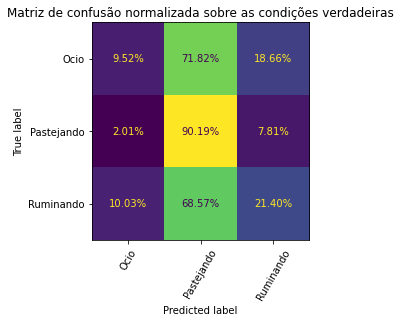


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  75.59806755786656
{'Ocio': {'precision': 0.7459732824427481, 'recall': 0.4785861207698712, 'f1-score': 0.5830872042722038, 'support': 81676, 'specificity': 0.9523092963014714, 'npv': 0.8619040361623544}, 'Pastejando': {'precision': 0.7626119574370359, 'recall': 0.9110784740939193, 'f1-score': 0.8302602744427069, 'support': 185883, 'specificity': 0.6985946576407629, 'npv': 0.88084287320857}, 'Ruminando': {'precision': 0.7449951341582094, 'recall': 0.6897605869481271, 'f1-score': 0.716314663814998, 'support': 93228, 'specificity': 0.9177340324937677, 'npv': 0.8946227470297409}, 'accuracy': 0.7559806755786656, 'macro avg': {'precision': 0.7511934580126645, 'recall': 0.6931417272706392, 'f1-score': 0.7098873808433028, 'support': 360787}, 'weighted avg': {'precision': 0.7542930279316162, 'recall': 0.7559806755786656, 'f1

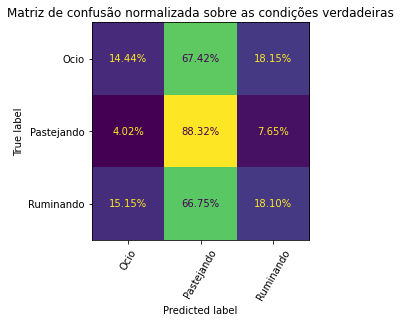


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.52702564116778
{'Ocio': {'precision': 0.9238747085898739, 'recall': 0.7569175767667369, 'f1-score': 0.8321040163669646, 'support': 81676, 'specificity': 0.9817491965562088, 'npv': 0.9324397439692926}, 'Pastejando': {'precision': 0.8704106925880923, 'recall': 0.9634393677743527, 'f1-score': 0.9145654222192716, 'support': 185883, 'specificity': 0.8475563737821891, 'npv': 0.9561653024761831}, 'Ruminando': {'precision': 0.8906503557608288, 'recall': 0.8418608143476208, 'f1-score': 0.865568599771711, 'support': 93228, 'specificity': 0.9639855134755325, 'npv': 0.9459301856483757}, 'accuracy': 0.8852702564116778, 'macro avg': {'precision': 0.894978585646265, 'recall': 0.8540725862962368, 'f1-score': 0.8707460127859824, 'support': 360787}, 'weighted avg': {'precision': 0.8877439953102786, 'recall': 0.8852702564116778, 'f

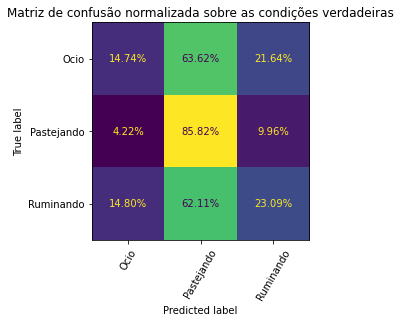


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.98586423568476
{'Ocio': {'precision': 0.9996083327213532, 'recall': 0.9999265390077868, 'f1-score': 0.9997674105448713, 'support': 81676, 'specificity': 0.9998853502728305, 'npv': 0.9999785011734776}, 'Pastejando': {'precision': 0.9999354404841964, 'recall': 0.9998924054378292, 'f1-score': 0.9999139224979691, 'support': 185883, 'specificity': 0.9999313909344555, 'npv': 0.9998856567874131}, 'Ruminando': {'precision': 0.9999249007617208, 'recall': 0.9997318402196765, 'f1-score': 0.9998283611710058, 'support': 93228, 'specificity': 0.9999738375461114, 'npv': 0.9999065689502461}, 'accuracy': 0.9998586423568476, 'macro avg': {'precision': 0.9998228913224234, 'recall': 0.9998502615550975, 'f1-score': 0.9998365647379487, 'support': 360787}, 'weighted avg': {'precision': 0.9998586654039274, 'recall': 0.9998586423568476, 

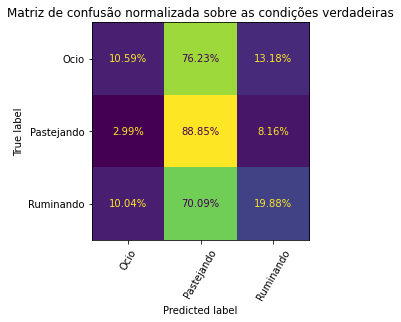


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  69.10808870607865
{'Ocio': {'precision': 0.5835803793899933, 'recall': 0.39285714285714285, 'f1-score': 0.469592196635421, 'support': 81676, 'specificity': 0.917968120210239, 'npv': 0.837840577624884}, 'Pastejando': {'precision': 0.7225042754506525, 'recall': 0.8704776660587574, 'f1-score': 0.7896182863389258, 'support': 185883, 'specificity': 0.6446850843891506, 'npv': 0.8240495783211775}, 'Ruminando': {'precision': 0.6773160987648288, 'recall': 0.5946604024541983, 'f1-score': 0.6333026805042294, 'support': 93228, 'specificity': 0.9012853239846165, 'npv': 0.8645244787334729}, 'accuracy': 0.6910808870607865, 'macro avg': {'precision': 0.6611335845351582, 'recall': 0.6193317371233662, 'f1-score': 0.6308377211595254, 'support': 360787}, 'weighted avg': {'precision': 0.6793775788936358, 'recall': 0.6910808870607865, 'f

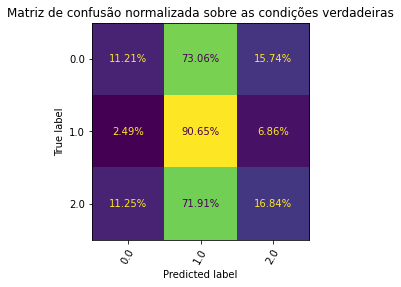


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  90.71917779742618
{'Ocio': {'precision': 0.9482570806100218, 'recall': 0.7886894558989177, 'f1-score': 0.861143789102187, 'support': 81676, 'specificity': 0.9874064440312277, 'npv': 0.941066398046815}, 'Pastejando': {'precision': 0.8963721817585628, 'recall': 0.9706105453430384, 'f1-score': 0.9320153631176693, 'support': 185883, 'specificity': 0.8807460092393542, 'npv': 0.9657511488379966}, 'Ruminando': {'precision': 0.9005099533725717, 'recall': 0.8845625777663363, 'f1-score': 0.8924650307080436, 'support': 93228, 'specificity': 0.9659476975171831, 'npv': 0.9600237732625089}, 'accuracy': 0.9071917779742619, 'macro avg': {'precision': 0.915046405247052, 'recall': 0.8812875263360974, 'f1-score': 0.8952080609759667, 'support': 360787}, 'weighted avg': {'precision': 0.9091872420867415, 'recall': 0.9071917779742619, 'f1

In [17]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)   

##### Com GLM 

In [18]:
df_test = df[df.Season_fall == 1]

In [19]:
df_train = df[df.Season_fall == 0]

         Current function value: 0.976426
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  58.235205773594245
{'Ocio': {'precision': 0.2335852971691122, 'recall': 0.11370577908179216, 'f1-score': 0.15295525864578952, 'support': 41581, 'specificity': 0.9242462716449688, 'npv': 0.8370216078046364}, 'Pastejando': {'precision': 0.6400415894121142, 'recall': 0.8522393250994005, 'f1-score': 0.731053526037599, 'support': 146629, 'specificity': 0.29533559267651954, 'npv': 0.5761819995696484}, 'Ruminando': {'precision': 0.44621113989637307, 'recall': 0.23694392378725088, 'f1-score': 0.30952568148888615, 'support': 58153, 'specificity': 0.9091387280165772, 'npv': 0.7940719221469907}, 'accuracy': 0.5823520577359425, 'macro avg': {'precision': 0.4399460088258665, 'recall': 0.4009630093228145, 'f1-score': 0.3978448220574249, 'support': 246363}, 'weighted avg': {'precision': 0.5256872374256342, 'recall': 0.5823520577359425, 'f1-score': 0.5339824853356262, 'support': 246363}}


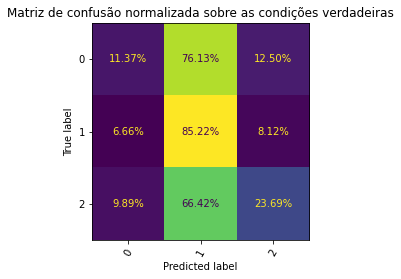

In [20]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 10 cm

In [21]:
df_test = df[df['Altura esperada'] == 10.0]

In [22]:
df_train = df[df['Altura esperada'] != 10.0]

In [23]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  54.15330827016921
{'Ocio': {'precision': 0.3623098800544083, 'recall': 0.07207694767656392, 'f1-score': 0.12023472444499159, 'support': 40651, 'specificity': 0.9520314767273134, 'npv': 0.7307027814266949}, 'Pastejando': {'precision': 0.5978118957510453, 'recall': 0.8708411574943425, 'f1-score': 0.7089478377610317, 'support': 83076, 'specificity': 0.2521549406142925, 'npv': 0.6046571607531042}, 'Ruminando': {'precision': 0.2601553479584339, 'recall': 0.20288965291421088, 'f1-score': 0.2279814193073633, 'support': 24432, 'specificity': 0.8860636724401303, 'npv': 0.8491537895511405}, 'accuracy': 0.5415330827016921, 'macro avg': {'precision': 0.4067590412546292, 'recall': 0.3819359193617058, 'f1-score': 0.35238799383779557, 'support': 148159}, 'weighted avg': {'precision': 0.47751534126732803, 'recall': 0.5

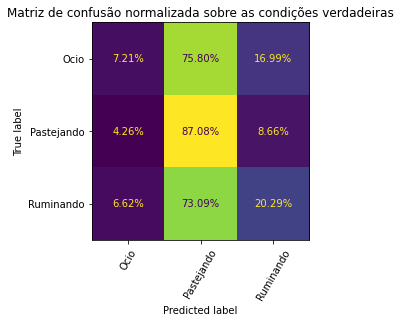


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  78.79500905246508
{'Ocio': {'precision': 0.74357806710687, 'recall': 0.434871558966661, 'f1-score': 0.5487904550211202, 'support': 82606, 'specificity': 0.9670868924106965, 'npv': 0.8863275543001851}, 'Pastejando': {'precision': 0.8095630056169852, 'recall': 0.9187246427941436, 'f1-score': 0.8606964052987197, 'support': 249436, 'specificity': 0.7427548853522942, 'npv': 0.8847607733016525}, 'Ruminando': {'precision': 0.7568058929550976, 'recall': 0.7607464414843756, 'f1-score': 0.758771051111923, 'support': 126949, 'specificity': 0.9065359201546792, 'npv': 0.9083441718143165}, 'accuracy': 0.7879500905246508, 'macro avg': {'precision': 0.7699823218929843, 'recall': 0.7047808810817268, 'f1-score': 0.722752637143921, 'support': 458991}, 'weighted avg': {'precision': 0.7830957883384754, 'recall': 0.7879500905246508, 'f1-

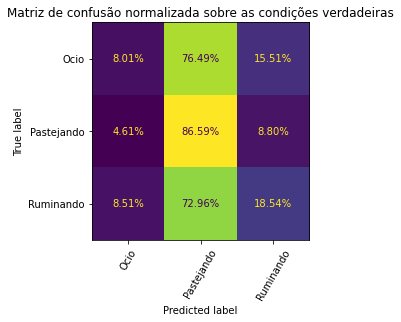


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.41896464200823
{'Ocio': {'precision': 0.9266990678033623, 'recall': 0.7040045517274774, 'f1-score': 0.8001458437957912, 'support': 82606, 'specificity': 0.9877784715118828, 'npv': 0.9382918260834452}, 'Pastejando': {'precision': 0.8875219813237089, 'recall': 0.9651493769944995, 'f1-score': 0.9247093754621281, 'support': 249436, 'specificity': 0.8544057645964067, 'npv': 0.9536961084063962}, 'Ruminando': {'precision': 0.8923373578806718, 'recall': 0.8785181450818833, 'f1-score': 0.885373831033771, 'support': 126949, 'specificity': 0.9594750061739178, 'npv': 0.953827453234653}, 'accuracy': 0.8941896464200824, 'macro avg': {'precision': 0.9021861356692477, 'recall': 0.8492240246012868, 'f1-score': 0.8700763500972301, 'support': 458991}, 'weighted avg': {'precision': 0.8959046503613766, 'recall': 0.8941896464200824, '

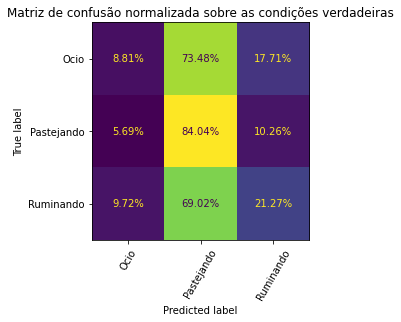


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.98714571745415
{'Ocio': {'precision': 0.9994796897498881, 'recall': 0.9999273660508922, 'f1-score': 0.999703477782014, 'support': 82606, 'specificity': 0.9998857552771763, 'npv': 0.9999840573086611}, 'Pastejando': {'precision': 0.9999558983898903, 'recall': 0.9999077919787039, 'f1-score': 0.9999318446057011, 'support': 249436, 'specificity': 0.9999475078141776, 'npv': 0.9998902498962146}, 'Ruminando': {'precision': 0.9999606063471054, 'recall': 0.9997636846292606, 'f1-score': 0.9998621357923055, 'support': 126949, 'specificity': 0.9999849416640063, 'npv': 0.9999096567861305}, 'accuracy': 0.9998714571745415, 'macro avg': {'precision': 0.9997987314956278, 'recall': 0.9998662808862856, 'f1-score': 0.9998324860600069, 'support': 458991}, 'weighted avg': {'precision': 0.9998714958189128, 'recall': 0.9998714571745415, 

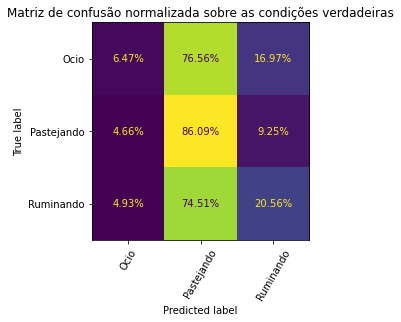


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  73.59577856646426
{'Ocio': {'precision': 0.5897887323943662, 'recall': 0.3244316393482314, 'f1-score': 0.4185995657810475, 'support': 82606, 'specificity': 0.9504762410829337, 'npv': 0.8650565468346105}, 'Pastejando': {'precision': 0.7801163737352022, 'recall': 0.887405987908722, 'f1-score': 0.8303096345116162, 'support': 249436, 'specificity': 0.7022738660494858, 'npv': 0.8397432239657632}, 'Ruminando': {'precision': 0.6906016485632848, 'recall': 0.7061654680225917, 'f1-score': 0.6982968464591308, 'support': 126949, 'specificity': 0.8790424102974925, 'npv': 0.8866824026903133}, 'accuracy': 0.7359577856646426, 'macro avg': {'precision': 0.6868355848976178, 'recall': 0.6393343650931818, 'f1-score': 0.6490686822505981, 'support': 458991}, 'weighted avg': {'precision': 0.7211043016325882, 'recall': 0.7359577856646426, 

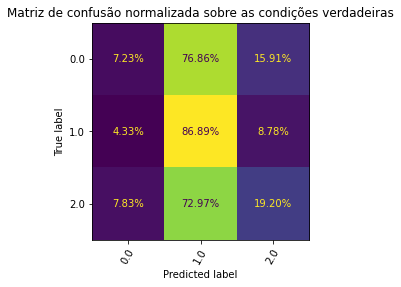


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  91.01725306160688
{'Ocio': {'precision': 0.932648189484127, 'recall': 0.728361135994964, 'f1-score': 0.8179420601150097, 'support': 82606, 'specificity': 0.9884559692867675, 'npv': 0.9431173776043845}, 'Pastejando': {'precision': 0.9134476660746811, 'recall': 0.9670857454417165, 'f1-score': 0.9395017516391799, 'support': 249436, 'specificity': 0.890926009878075, 'npv': 0.9578775627475526}, 'Ruminando': {'precision': 0.8924200128838308, 'recall': 0.9166515687402027, 'f1-score': 0.9043735063824826, 'support': 126949, 'specificity': 0.9577523325362454, 'npv': 0.9677992665743544}, 'accuracy': 0.9101725306160687, 'macro avg': {'precision': 0.9128386228142129, 'recall': 0.8706994833922944, 'f1-score': 0.8872724393788908, 'support': 458991}, 'weighted avg': {'precision': 0.9110873559418798, 'recall': 0.9101725306160687, 'f

In [24]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [25]:
df_test = df[df['Altura esperada'] == 10.0]

In [26]:
df_train = df[df['Altura esperada'] != 10.0]

         Current function value: 0.928654
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  46.63570893432056
{'Ocio': {'precision': 0.3098636728147554, 'recall': 0.04752650611301075, 'f1-score': 0.08241266049567035, 'support': 40651, 'specificity': 0.9599750716225769, 'npv': 0.727184972238663}, 'Pastejando': {'precision': 0.5646786846069926, 'recall': 0.7850281669796331, 'f1-score': 0.6568665961625624, 'support': 83076, 'specificity': 0.22749412288923374, 'npv': 0.4532680238787693}, 'Ruminando': {'precision': 0.07362845251608022, 'recall': 0.07964963981663392, 'f1-score': 0.07652078172309387, 'support': 24432, 'specificity': 0.8021127158987125, 'npv': 0.8152781999359232}, 'accuracy': 0.46635708934320563, 'macro avg': {'precision': 0.3160569366459427, 'recall': 0.3040681043030926, 'f1-score': 0.27193334612710884, 'support': 148159}, 'weighted avg': {'precision': 0.4137879232302864, 'recall': 0.46635708934320563, 'f1-score': 0.40354998443340706, 'support': 148159}}


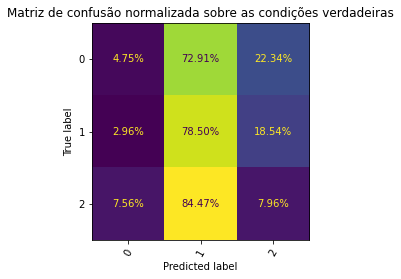

In [27]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 15 cm

In [28]:
df_test = df[df['Altura esperada'] == 15.0]

In [29]:
df_train = df[df['Altura esperada'] != 15.0]

In [30]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  60.75648501222619
{'Ocio': {'precision': 0.10968379446640317, 'recall': 0.09592395218205386, 'f1-score': 0.10234344986553975, 'support': 6943, 'specificity': 0.895106523342, 'npv': 0.8802304947623499}, 'Pastejando': {'precision': 0.7086635206125902, 'recall': 0.821849910937863, 'f1-score': 0.7610714669917883, 'support': 38737, 'specificity': 0.3371150729335494, 'npv': 0.4909640775982887}, 'Ruminando': {'precision': 0.4046760187040748, 'recall': 0.2366221388953988, 'f1-score': 0.29862959676624273, 'support': 12801, 'specificity': 0.9024518388791594, 'npv': 0.8083771276178524}, 'accuracy': 0.6075648501222619, 'macro avg': {'precision': 0.4076744445943561, 'recall': 0.38479866733843854, 'f1-score': 0.387348171207857, 'support': 58481}, 'weighted avg': {'precision': 0.5710109454075855, 'recall': 0.607564850

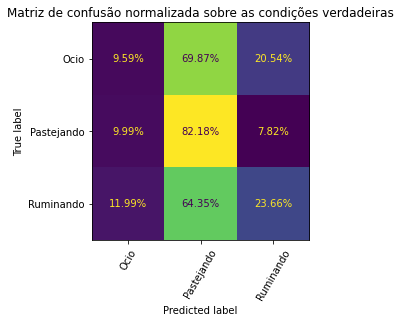


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  77.05264922931676
{'Ocio': {'precision': 0.7252987296675292, 'recall': 0.47958113382739825, 'f1-score': 0.5773846798776544, 'support': 116314, 'specificity': 0.9511350626221508, 'npv': 0.8716889944039342}, 'Pastejando': {'precision': 0.7914879031781489, 'recall': 0.9118134626840269, 'f1-score': 0.847400630485708, 'support': 293775, 'specificity': 0.7231476613808093, 'npv': 0.876770059885936}, 'Ruminando': {'precision': 0.7434070384926945, 'recall': 0.7152114302208111, 'f1-score': 0.7290367188419442, 'support': 138580, 'specificity': 0.9165790840524861, 'npv': 0.9049801971854723}, 'accuracy': 0.7705264922931676, 'macro avg': {'precision': 0.7533978904461242, 'recall': 0.7022020089107454, 'f1-score': 0.7179406764017688, 'support': 548669}, 'weighted avg': {'precision': 0.7653122421588012, 'recall': 0.7705264922931676,

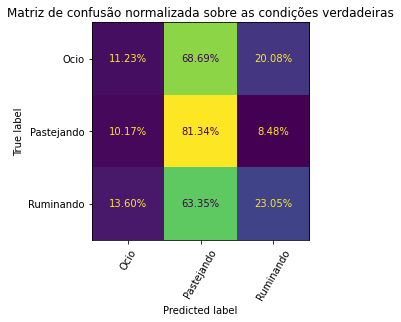


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.3316371072541
{'Ocio': {'precision': 0.922353388782617, 'recall': 0.7503310005674295, 'f1-score': 0.8274966221821888, 'support': 116314, 'specificity': 0.983007019694464, 'npv': 0.9360420043695821}, 'Pastejando': {'precision': 0.8848652595578965, 'recall': 0.9652659348140584, 'f1-score': 0.9233186214576317, 'support': 293775, 'specificity': 0.855245709981404, 'npv': 0.955285033807915}, 'Ruminando': {'precision': 0.8930229076209013, 'recall': 0.8608024245922933, 'f1-score': 0.8766166960611405, 'support': 138580, 'specificity': 0.9651539056156103, 'npv': 0.9535280385652234}, 'accuracy': 0.893316371072541, 'macro avg': {'precision': 0.9000805186538049, 'recall': 0.8587997866579271, 'f1-score': 0.875810646566987, 'support': 548669}, 'weighted avg': {'precision': 0.8948728982821826, 'recall': 0.893316371072541, 'f1-sc

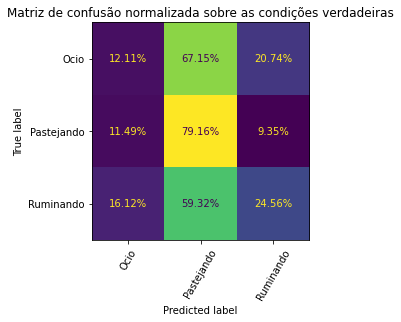


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.98760637105431
{'Ocio': {'precision': 0.9995445287591417, 'recall': 0.9999656103306567, 'f1-score': 0.999755025206617, 'support': 116314, 'specificity': 0.9998774155497219, 'npv': 0.9999907472947402}, 'Pastejando': {'precision': 0.9999591508830218, 'recall': 0.9999217087907412, 'f1-score': 0.9999404294863831, 'support': 293775, 'specificity': 0.9999529216066286, 'npv': 0.9999097703065848}, 'Ruminando': {'precision': 0.9999783459167617, 'recall': 0.9997041420118343, 'f1-score': 0.999841225164368, 'support': 138580, 'specificity': 0.9999926845148248, 'npv': 0.9999000309660179}, 'accuracy': 0.9998760637105432, 'macro avg': {'precision': 0.9998273418529751, 'recall': 0.999863820377744, 'f1-score': 0.999845559952456, 'support': 548669}, 'weighted avg': {'precision': 0.9998761020686341, 'recall': 0.9998760637105432, 'f

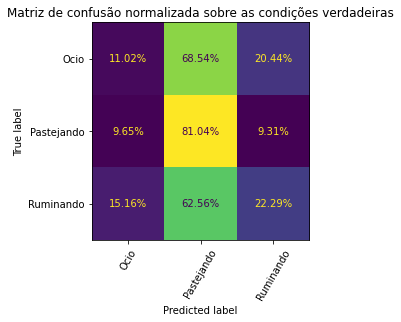


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  72.11834457569135
{'Ocio': {'precision': 0.5997752779966162, 'recall': 0.3992640610760528, 'f1-score': 0.4793979653458447, 'support': 116314, 'specificity': 0.9283251032137942, 'npv': 0.8517231134878194}, 'Pastejando': {'precision': 0.7655376862076633, 'recall': 0.8790230618670751, 'f1-score': 0.8183647599429568, 'support': 293775, 'specificity': 0.6897141556882469, 'npv': 0.8318381406616701}, 'Ruminando': {'precision': 0.6796550050405108, 'recall': 0.6567758695338433, 'f1-score': 0.6680195966898476, 'support': 138580, 'specificity': 0.8953910004901375, 'npv': 0.8853199728031556}, 'accuracy': 0.7211834457569135, 'macro avg': {'precision': 0.6816559897482634, 'recall': 0.6450209974923237, 'f1-score': 0.655260773992883, 'support': 548669}, 'weighted avg': {'precision': 0.7087054053519858, 'recall': 0.7211834457569135,

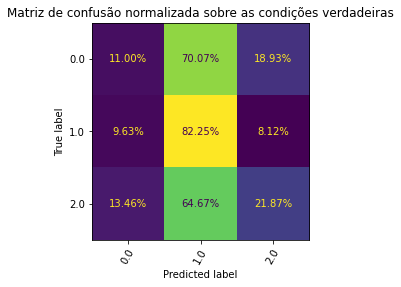


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.5649289462317
{'Ocio': {'precision': 0.9186254295532646, 'recall': 0.7469350207197758, 'f1-score': 0.8239310727444296, 'support': 116314, 'specificity': 0.9821998126539534, 'npv': 0.9351786194047929}, 'Pastejando': {'precision': 0.8968882400545867, 'recall': 0.9619777040251893, 'f1-score': 0.9282933959630135, 'support': 293775, 'specificity': 0.8725352499470368, 'npv': 0.9521778965124543}, 'Ruminando': {'precision': 0.877207749696041, 'recall': 0.8798600086592582, 'f1-score': 0.8785318774114756, 'support': 138580, 'specificity': 0.9583797663434035, 'npv': 0.9593599726609222}, 'accuracy': 0.895649289462317, 'macro avg': {'precision': 0.8975738064346307, 'recall': 0.8629242444680744, 'f1-score': 0.8769187820396396, 'support': 548669}, 'weighted avg': {'precision': 0.8965255753249628, 'recall': 0.895649289462317, 'f

In [31]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [32]:
df_test = df[df['Altura esperada'] == 15.0]

In [33]:
df_train = df[df['Altura esperada'] != 15.0]

         Current function value: 0.964205
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  65.08438638190182
{'Ocio': {'precision': 0.3191489361702128, 'recall': 0.002160449373469682, 'f1-score': 0.004291845493562232, 'support': 6943, 'specificity': 0.9993790989173037, 'npv': 0.8814388883184447}, 'Pastejando': {'precision': 0.6754947235668317, 'recall': 0.9402380153341766, 'f1-score': 0.7861768261094803, 'support': 38737, 'specificity': 0.11380672609400325, 'npv': 0.49254712845243315}, 'Ruminando': {'precision': 0.3599114064230343, 'recall': 0.12694320756190922, 'f1-score': 0.18768768768768768, 'support': 12801, 'specificity': 0.9367338003502627, 'npv': 0.7929066449245822}, 'accuracy': 0.6508438638190182, 'macro avg': {'precision': 0.4515183553866929, 'recall': 0.3564472240898518, 'f1-score': 0.3260521197635767, 'support': 58481}, 'weighted avg': {'precision': 0.5641099858801903, 'recall': 0.6508438638190182, 'f1-score': 0.5623453786076645, 'support': 58481}}


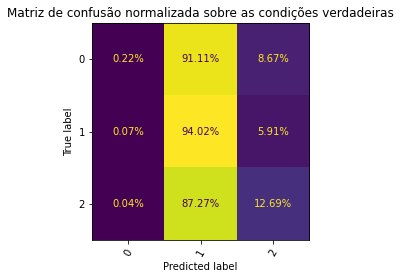

In [34]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 20 cm

In [35]:
df_test = df[df['Altura esperada'] == 20.0]

In [36]:
df_train = df[df['Altura esperada'] != 20.0]

In [37]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  54.09594994567457
{'Ocio': {'precision': 0.33590852904820767, 'recall': 0.12457976772616138, 'f1-score': 0.18175231300858324, 'support': 26176, 'specificity': 0.9200004963518141, 'npv': 0.7638991922189251}, 'Pastejando': {'precision': 0.5916231040609791, 'recall': 0.8490363827860825, 'f1-score': 0.6973327768714194, 'support': 54119, 'specificity': 0.3975306296894292, 'npv': 0.7192246889820606}, 'Ruminando': {'precision': 0.4406910778751934, 'recall': 0.3228304809399675, 'f1-score': 0.37266403541289606, 'support': 26469, 'specificity': 0.8649355501587894, 'npv': 0.7948588825050931}, 'accuracy': 0.5409594994567457, 'macro avg': {'precision': 0.4560742369947934, 'recall': 0.43214887715073713, 'f1-score': 0.41724970843096626, 'support': 106764}, 'weighted avg': {'precision': 0.4915087910280666, 'recall': 0.

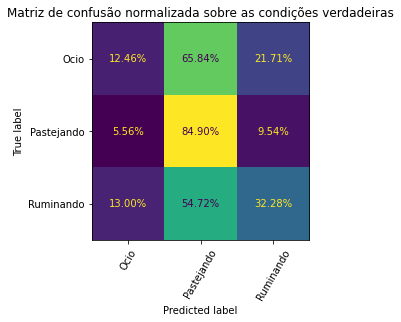


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  78.50019784726192
{'Ocio': {'precision': 0.742022906920471, 'recall': 0.4738105293517784, 'f1-score': 0.578332945665772, 'support': 97081, 'specificity': 0.9603476277259146, 'npv': 0.8834774952326208}, 'Pastejando': {'precision': 0.8059879525257947, 'recall': 0.9223148570545955, 'f1-score': 0.8602365963890741, 'support': 278393, 'specificity': 0.7215813111224227, 'npv': 0.8810481098711314}, 'Ruminando': {'precision': 0.75144170985537, 'recall': 0.7208274625336236, 'f1-score': 0.735816291090363, 'support': 124912, 'specificity': 0.9206789285010414, 'npv': 0.9083673399673642}, 'accuracy': 0.7850019784726191, 'macro avg': {'precision': 0.7664841897672119, 'recall': 0.7056509496466657, 'f1-score': 0.7247952777150696, 'support': 500386}, 'weighted avg': {'precision': 0.7799615032309333, 'recall': 0.7850019784726191, 'f1-

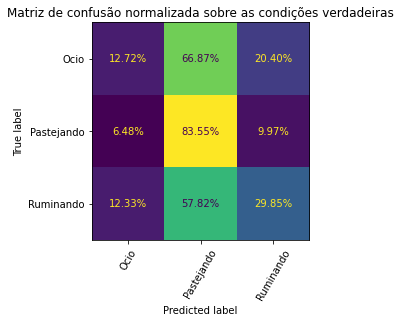


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.52128956445624
{'Ocio': {'precision': 0.9232796676188003, 'recall': 0.7324914246866019, 'f1-score': 0.8168936421961964, 'support': 97081, 'specificity': 0.9853485575432985, 'npv': 0.9386582767628955}, 'Pastejando': {'precision': 0.8888031880704461, 'recall': 0.9685803881563114, 'f1-score': 0.9269785174311675, 'support': 278393, 'specificity': 0.8480357488749646, 'npv': 0.9556001116722925}, 'Ruminando': {'precision': 0.8934033420844272, 'recall': 0.8581641475598821, 'f1-score': 0.8754292620979433, 'support': 124912, 'specificity': 0.9659363897367061, 'npv': 0.9534254641812193}, 'accuracy': 0.8952128956445624, 'macro avg': {'precision': 0.9018287325912245, 'recall': 0.8530786534675984, 'f1-score': 0.8731004739084357, 'support': 500386}, 'weighted avg': {'precision': 0.8966403888499006, 'recall': 0.8952128956445624,

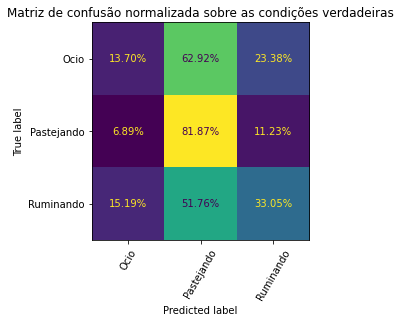


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.98820910257281
{'Ocio': {'precision': 0.9995366652251807, 'recall': 0.9999587972929822, 'f1-score': 0.9997476866989696, 'support': 97081, 'specificity': 0.9998884219139361, 'npv': 0.9999900809395335}, 'Pastejando': {'precision': 0.9999712622000941, 'recall': 0.9999209750245157, 'f1-score': 0.9999461179800709, 'support': 278393, 'specificity': 0.9999639628276568, 'npv': 0.9999009040255488}, 'Ruminando': {'precision': 0.9999519557993354, 'recall': 0.9997358140130652, 'f1-score': 0.9998438732250586, 'support': 124912, 'specificity': 0.9999840201984691, 'npv': 0.9999121174111387}, 'accuracy': 0.9998820910257281, 'macro avg': {'precision': 0.99981996107487, 'recall': 0.9998718621101877, 'f1-score': 0.9998458926346997, 'support': 500386}, 'weighted avg': {'precision': 0.9998821255934481, 'recall': 0.9998820910257281, '

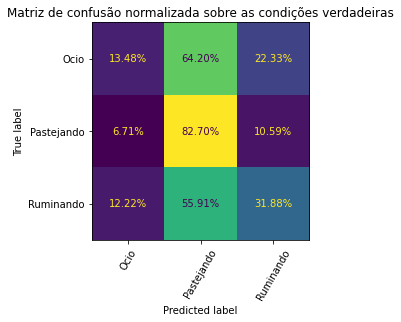


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  73.71449241185805
{'Ocio': {'precision': 0.6200687400452678, 'recall': 0.380960229087051, 'f1-score': 0.4719574288886336, 'support': 97081, 'specificity': 0.9438117553712451, 'npv': 0.8636455423933784}, 'Pastejando': {'precision': 0.7800426120763503, 'recall': 0.8929498945734986, 'f1-score': 0.832686297694454, 'support': 278393, 'specificity': 0.6842332866351641, 'npv': 0.8359796804570246}, 'Ruminando': {'precision': 0.6823485071936551, 'recall': 0.6667253746637632, 'f1-score': 0.6744464780291864, 'support': 124912, 'specificity': 0.8967438491080607, 'npv': 0.8899649516036096}, 'accuracy': 0.7371449241185805, 'macro avg': {'precision': 0.6941532864384244, 'recall': 0.6468784994414376, 'f1-score': 0.659696734870758, 'support': 500386}, 'weighted avg': {'precision': 0.7246182207069739, 'recall': 0.7371449241185805, 'f

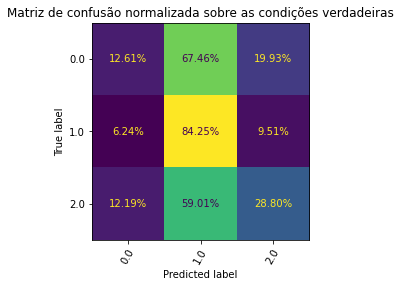


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  90.71916480477071
{'Ocio': {'precision': 0.9309685803837627, 'recall': 0.7526498490950856, 'f1-score': 0.832365991330945, 'support': 97081, 'specificity': 0.9865659984379068, 'npv': 0.9430836691159042}, 'Pastejando': {'precision': 0.9082805164714519, 'recall': 0.9687851346837025, 'f1-score': 0.9375576841852777, 'support': 278393, 'specificity': 0.8773159514038731, 'npv': 0.9572863827611969}, 'Ruminando': {'precision': 0.8896704598197852, 'recall': 0.8900265787114129, 'f1-score': 0.8898484836357524, 'support': 124912, 'specificity': 0.9632810793823274, 'npv': 0.9634093718036141}, 'accuracy': 0.9071916480477071, 'macro avg': {'precision': 0.9096398522249999, 'recall': 0.8704871874967336, 'f1-score': 0.8865907197173252, 'support': 500386}, 'weighted avg': {'precision': 0.9080366258274253, 'recall': 0.9071916480477071, 

In [38]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [39]:
df_test = df[df['Altura esperada'] == 20.0]

In [40]:
df_train = df[df['Altura esperada'] != 20.0]

         Current function value: 0.935728
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  52.51863924169196
{'Ocio': {'precision': 0.28470961887477314, 'recall': 0.047944682151589244, 'f1-score': 0.08206905571540675, 'support': 26176, 'specificity': 0.9608750682483744, 'npv': 0.7565262417444996}, 'Pastejando': {'precision': 0.5335287381680272, 'recall': 0.93839501838541, 'f1-score': 0.6802807656758603, 'support': 54119, 'specificity': 0.15657707284642416, 'npv': 0.7120152025567936}, 'Ruminando': {'precision': 0.5622820477053982, 'recall': 0.15229135970380445, 'f1-score': 0.23966942148760328, 'support': 26469, 'specificity': 0.9609191107790024, 'npv': 0.7747075656408454}, 'accuracy': 0.5251863924169196, 'macro avg': {'precision': 0.4601734682493995, 'recall': 0.37954368674693456, 'f1-score': 0.3340064142929568, 'support': 106764}, 'weighted avg': {'precision': 0.4796527320566456, 'recall': 0.5251863924169196, 'f1-score': 0.424376796273779, 'support': 106764}}


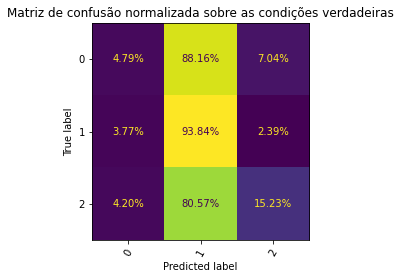

In [41]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 25 cm

In [42]:
df_test = df[df['Altura esperada'] == 25.0]

In [43]:
df_train = df[df['Altura esperada'] != 25.0]

In [44]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  54.2840772770407
{'Ocio': {'precision': 0.2606598155732556, 'recall': 0.2211751662971175, 'f1-score': 0.2392996782118266, 'support': 46904, 'specificity': 0.8733597014861136, 'npv': 0.8474458773219297}, 'Pastejando': {'precision': 0.6166921227335279, 'recall': 0.8281324037094699, 'f1-score': 0.7069408368991451, 'support': 147730, 'specificity': 0.42185135905721344, 'npv': 0.6860548507554962}, 'Ruminando': {'precision': 0.4595739500912964, 'recall': 0.22307701397998134, 'f1-score': 0.30035959775967414, 'support': 84621, 'specificity': 0.8859500395614333, 'npv': 0.7239734654463011}, 'accuracy': 0.542840772770407, 'macro avg': {'precision': 0.44564196279935997, 'recall': 0.4241281946621896, 'f1-score': 0.415533370956882, 'support': 279255}, 'weighted avg': {'precision': 0.5092819197928333, 'recall': 0.5428

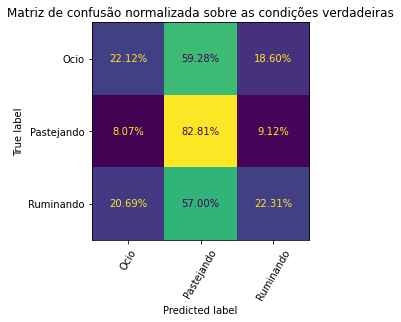


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  79.86886045837845
{'Ocio': {'precision': 0.7819741846044325, 'recall': 0.546684478671434, 'f1-score': 0.6434958221564455, 'support': 76353, 'specificity': 0.9537333725580619, 'npv': 0.8739162744612335}, 'Pastejando': {'precision': 0.8086034912718204, 'recall': 0.9405569806582892, 'f1-score': 0.8696030701644659, 'support': 184782, 'specificity': 0.7125488250543277, 'npv': 0.9027611788347985}, 'Ruminando': {'precision': 0.7778952668680765, 'recall': 0.6942330736968244, 'f1-score': 0.7336868766819694, 'support': 66760, 'specificity': 0.9493250617496697, 'npv': 0.9239215101652908}, 'accuracy': 0.7986886045837844, 'macro avg': {'precision': 0.7894909809147764, 'recall': 0.7271581776755158, 'f1-score': 0.748928589667627, 'support': 327895}, 'weighted avg': {'precision': 0.7961503934412069, 'recall': 0.7986886045837844, 'f

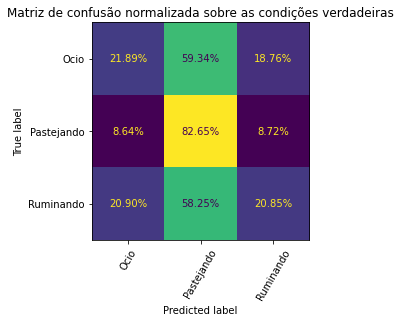


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.55885268149865
{'Ocio': {'precision': 0.927574404996609, 'recall': 0.770251332626092, 'f1-score': 0.8416239732104525, 'support': 76353, 'specificity': 0.981744599311447, 'npv': 0.933676632941639}, 'Pastejando': {'precision': 0.8848843728790219, 'recall': 0.9736879133248909, 'f1-score': 0.9271646036670206, 'support': 184782, 'specificity': 0.8364509164087119, 'npv': 0.960969422569018}, 'Ruminando': {'precision': 0.898015237223294, 'recall': 0.8227681246255243, 'f1-score': 0.8587464627988055, 'support': 66760, 'specificity': 0.9761119727344094, 'npv': 0.9556403690637314}, 'accuracy': 0.8955885268149865, 'macro avg': {'precision': 0.9034913383663082, 'recall': 0.8555691235255024, 'f1-score': 0.8758450132254262, 'support': 327895}, 'weighted avg': {'precision': 0.8974985589016746, 'recall': 0.8955885268149865, 'f1-sc

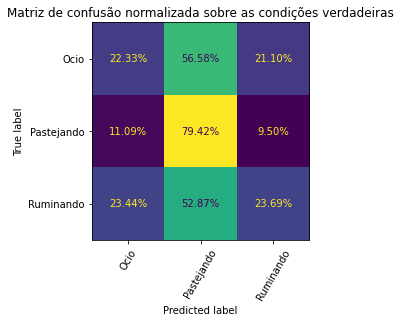


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.98841092422879
{'Ocio': {'precision': 0.9996334022886172, 'recall': 0.9999607088130132, 'f1-score': 0.9997970287629886, 'support': 76353, 'specificity': 0.9998886865811674, 'npv': 0.9999880723768174}, 'Pastejando': {'precision': 0.9999567048025197, 'recall': 0.9999350586096049, 'f1-score': 0.9999458815889166, 'support': 184782, 'specificity': 0.999944100116691, 'npv': 0.9999161525185687}, 'Ruminando': {'precision': 0.9999700325147215, 'recall': 0.9996554823247453, 'f1-score': 0.9998127326796455, 'support': 66760, 'specificity': 0.9999923411262374, 'npv': 0.9999119300341558}, 'accuracy': 0.9998841092422879, 'macro avg': {'precision': 0.9998533798686194, 'recall': 0.9998504165824545, 'f1-score': 0.9998518810105169, 'support': 327895}, 'weighted avg': {'precision': 0.9998841347457107, 'recall': 0.9998841092422879, '

/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  53.61945175556391
{'Ocio': {'precision': 0.24695439099378164, 'recall': 0.22776309056796862, 'f1-score': 0.23697081951576587, 'support': 46904, 'specificity': 0.8597983223657312, 'npv': 0.8465185850607637}, 'Pastejando': {'precision': 0.6212413579609948, 'recall': 0.8150612604075002, 'f1-score': 0.7050739276826233, 'support': 147730, 'specificity': 0.4418475574985744, 'npv': 0.6802130274477673}, 'Ruminando': {'precision': 0.4420286418816389, 'recall': 0.220311742947968, 'f1-score': 0.29406058502961424, 'support': 84621, 'specificity': 0.8790910118478786, 'npv': 0.7217045794861628}, 'accuracy': 0.5361945175556391, 'macro avg': {'precision': 0.43674146361213845, 'recall': 0.42104536464114556, 'f1-score': 0.41203511074266785, 'support': 279255}, 'weighted avg': {'precision': 0.504069901242292, 'recall': 0.536194517555639

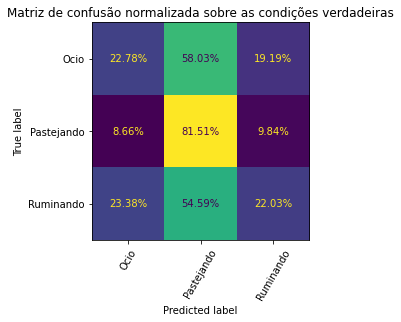


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  73.61807895820309
{'Ocio': {'precision': 0.6459753281135583, 'recall': 0.4505913323641507, 'f1-score': 0.5308767706693824, 'support': 76353, 'specificity': 0.9250423388539488, 'npv': 0.847256004311161}, 'Pastejando': {'precision': 0.7709384693735821, 'recall': 0.901142968470955, 'f1-score': 0.830971225534718, 'support': 184782, 'specificity': 0.6542941591609428, 'npv': 0.8367633260354765}, 'Ruminando': {'precision': 0.6900896906864918, 'recall': 0.6062162971839424, 'f1-score': 0.64543961213977, 'support': 66760, 'specificity': 0.9303999846822525, 'npv': 0.9023617543612047}, 'accuracy': 0.7361807895820308, 'macro avg': {'precision': 0.7023344960578775, 'recall': 0.6526501993396827, 'f1-score': 0.6690958694479568, 'support': 327895}, 'weighted avg': {'precision': 0.7253788384253311, 'recall': 0.7361807895820308, 'f1-s

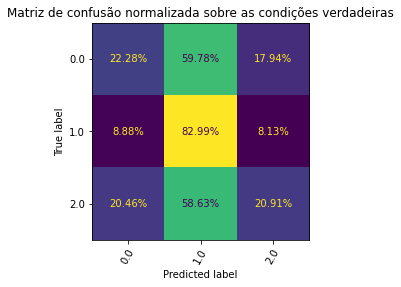


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  92.56591286844873
{'Ocio': {'precision': 0.9487515831373259, 'recall': 0.8241326470472673, 'f1-score': 0.8820622805357556, 'support': 76353, 'specificity': 0.9864873460495662, 'npv': 0.9486640338569643}, 'Pastejando': {'precision': 0.9179046288138855, 'recall': 0.9810912318299402, 'f1-score': 0.9484467045442656, 'support': 184782, 'specificity': 0.8867049115034973, 'npv': 0.9732040830412676}, 'Ruminando': {'precision': 0.9256582746726186, 'recall': 0.8883463151587777, 'f1-score': 0.9066185631626016, 'support': 66760, 'specificity': 0.9817603921343366, 'npv': 0.9717465299098649}, 'accuracy': 0.9256591286844874, 'macro avg': {'precision': 0.9307714955412766, 'recall': 0.8978567313453284, 'f1-score': 0.9123758494142077, 'support': 327895}, 'weighted avg': {'precision': 0.9266662473228187, 'recall': 0.9256591286844874, 

In [45]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [46]:
df_test = df[df['Altura esperada'] == 25.0]

In [47]:
df_train = df[df['Altura esperada'] != 25.0]

         Current function value: 0.946505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  54.13117043562335
{'Ocio': {'precision': 0.317956388254743, 'recall': 0.08611205867303429, 'f1-score': 0.13552099585619137, 'support': 46904, 'specificity': 0.9627115872107286, 'npv': 0.8391871004531949}, 'Pastejando': {'precision': 0.5574088208144687, 'recall': 0.9442293373045421, 'f1-score': 0.7009967862625917, 'support': 147730, 'specificity': 0.15789393651397074, 'npv': 0.7159553195890506}, 'Ruminando': {'precision': 0.468257375943078, 'recall': 0.09021401307004172, 'f1-score': 0.15128215290713806, 'support': 84621, 'specificity': 0.9554599915739285, 'npv': 0.7072203291855548}, 'accuracy': 0.5413117043562335, 'macro avg': {'precision': 0.44787419500409653, 'recall': 0.3735184696825394, 'f1-score': 0.3292666450086404, 'support': 279255}, 'weighted avg': {'precision': 0.49017506917799547, 'recall': 0.5413117043562335, 'f1-score': 0.43944201208704015, 'support': 279255}}


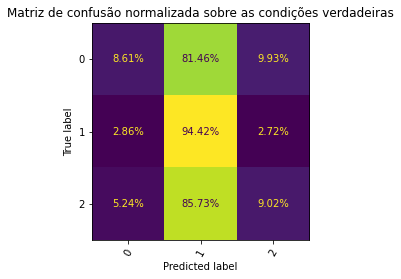

In [48]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Animals Out

In [49]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [50]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [51]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [52]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [53]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [54]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  52.6501240933028
{'Ocio': {'precision': 0.27802622217705053, 'recall': 0.1457728277956889, 'f1-score': 0.19126361236868325, 'support': 37531, 'specificity': 0.9168111020025764, 'npv': 0.8300403428880418}, 'Pastejando': {'precision': 0.5891886925362163, 'recall': 0.8422988344702576, 'f1-score': 0.693366780560241, 'support': 114197, 'specificity': 0.28738551118855854, 'npv': 0.6002974076704546}, 'Ruminando': {'precision': 0.3159035384979116, 'recall': 0.1416856653058339, 'f1-score': 0.1956296287258574, 'support': 56583, 'specificity': 0.885578139829168, 'npv': 0.7345148223666589}, 'accuracy': 0.526501240933028, 'macro avg': {'precision': 0.3943728177370595, 'recall': 0.3765857758572601, 'f1-score': 0.36008667388492727, 'support': 208311}, 'weighted avg': {'precision': 0.45889536887112303, 'recall': 0.5265

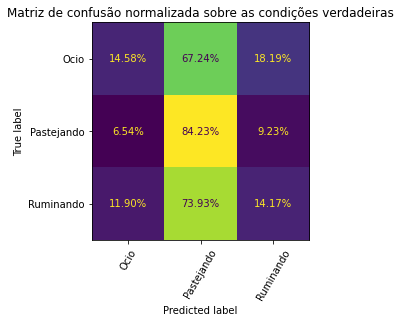


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  79.08780234631017
{'Ocio': {'precision': 0.7678730892472554, 'recall': 0.5115600867881389, 'f1-score': 0.6140425800037805, 'support': 85726, 'specificity': 0.9576606528633432, 'npv': 0.8774698005431221}, 'Pastejando': {'precision': 0.8065656626049801, 'recall': 0.9268808831275909, 'f1-score': 0.8625478478077392, 'support': 218315, 'specificity': 0.7311770180142253, 'npv': 0.8921112748212331}, 'Ruminando': {'precision': 0.762017457923762, 'recall': 0.730258022321146, 'f1-score': 0.7457997791483746, 'support': 94798, 'specificity': 0.9288911692830901, 'npv': 0.9169751162367854}, 'accuracy': 0.7908780234631017, 'macro avg': {'precision': 0.7788187365919992, 'recall': 0.7228996640789586, 'f1-score': 0.7407967356532982, 'support': 398839}, 'weighted avg': {'precision': 0.7876606902952651, 'recall': 0.7908780234631017, 'f

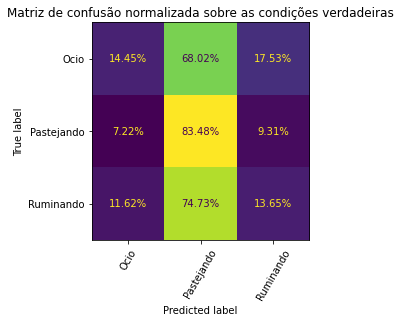


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  89.75250665055323
{'Ocio': {'precision': 0.9262922239854908, 'recall': 0.7625924456990878, 'f1-score': 0.8365088098680759, 'support': 85726, 'specificity': 0.9833861896503818, 'npv': 0.9380009321793805}, 'Pastejando': {'precision': 0.8902257222269013, 'recall': 0.9682935208299933, 'f1-score': 0.9276199879326422, 'support': 218315, 'specificity': 0.8556036870443819, 'npv': 0.9571071824710774}, 'Ruminando': {'precision': 0.8942545951124963, 'recall': 0.8565687039810966, 'f1-score': 0.8750060613897553, 'support': 94798, 'specificity': 0.9684187329998257, 'npv': 0.955859055435079}, 'accuracy': 0.8975250665055323, 'macro avg': {'precision': 0.9035908471082962, 'recall': 0.8624848901700592, 'f1-score': 0.8797116197301578, 'support': 398839}, 'weighted avg': {'precision': 0.8989354171703884, 'recall': 0.8975250665055323, '

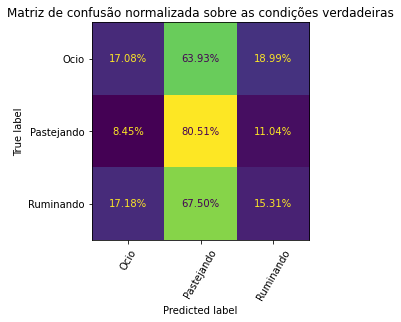


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.9882157963489
{'Ocio': {'precision': 0.9995918700514244, 'recall': 0.9999533397102396, 'f1-score': 0.9997725722083238, 'support': 85726, 'specificity': 0.9998882192690818, 'npv': 0.9999872237944053}, 'Pastejando': {'precision': 0.9999633545266321, 'recall': 0.9999312919405446, 'f1-score': 0.9999473229765725, 'support': 218315, 'specificity': 0.9999556845627174, 'npv': 0.9999169117769248}, 'Ruminando': {'precision': 0.9999577943317788, 'recall': 0.9997046351188844, 'f1-score': 0.99983119870023, 'support': 94798, 'specificity': 0.9999868438796083, 'npv': 0.9999079144261918}, 'accuracy': 0.999882157963489, 'macro avg': {'precision': 0.9998376729699451, 'recall': 0.999863088923223, 'f1-score': 0.9998503646283754, 'support': 398839}, 'weighted avg': {'precision': 0.9998821865027595, 'recall': 0.999882157963489, 'f1-sc

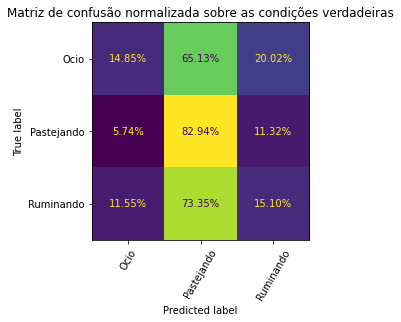


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  73.00138652438703
{'Ocio': {'precision': 0.6292709528197221, 'recall': 0.3903599841355015, 'f1-score': 0.48182570821784676, 'support': 85726, 'specificity': 0.9370355111413451, 'npv': 0.8488051842851356}, 'Pastejando': {'precision': 0.7701739975199627, 'recall': 0.8933192863522891, 'f1-score': 0.8271885345158492, 'support': 218315, 'specificity': 0.6776218120582305, 'npv': 0.8400598831180426}, 'Ruminando': {'precision': 0.677957117202882, 'recall': 0.6610793476655625, 'f1-score': 0.6694118652395907, 'support': 94798, 'specificity': 0.9020888630151854, 'npv': 0.8951406816557387}, 'accuracy': 0.7300138652438704, 'macro avg': {'precision': 0.6924673558475223, 'recall': 0.6482528727177844, 'f1-score': 0.6594753693244289, 'support': 398839}, 'weighted avg': {'precision': 0.7179698995499261, 'recall': 0.7300138652438704, 

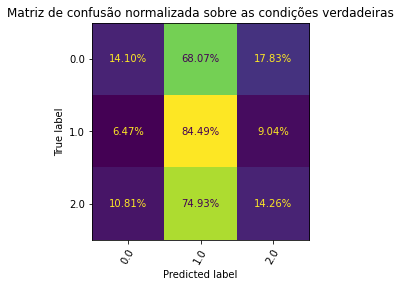


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  92.68501826551567
{'Ocio': {'precision': 0.9520950663013095, 'recall': 0.8065697687982643, 'f1-score': 0.8733114828638009, 'support': 85726, 'specificity': 0.9888889953467278, 'npv': 0.949168648993305}, 'Pastejando': {'precision': 0.9256454703038044, 'recall': 0.9759567597279161, 'f1-score': 0.9501355641967822, 'support': 218315, 'specificity': 0.905192661363586, 'npv': 0.968877847478329}, 'Ruminando': {'precision': 0.9106471598896235, 'recall': 0.9225300111816706, 'f1-score': 0.916550072576546, 'support': 94798, 'specificity': 0.9717768327297963, 'npv': 0.9757466876263193}, 'accuracy': 0.9268501826551566, 'macro avg': {'precision': 0.9294625654982459, 'recall': 0.9016855132359503, 'f1-score': 0.9133323732123765, 'support': 398839}, 'weighted avg': {'precision': 0.9277656446995847, 'recall': 0.9268501826551566, 'f1-

In [55]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)

##### Com GLM 

In [56]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [57]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

         Current function value: 0.941192
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  54.80459505258963
{'Ocio': {'precision': 0.4977180527383367, 'recall': 0.10460685833044683, 'f1-score': 0.17287919152777473, 'support': 37531, 'specificity': 0.9768005621267127, 'npv': 0.8323296228476772}, 'Pastejando': {'precision': 0.5626411185914034, 'recall': 0.9513910172771614, 'f1-score': 0.7071074563044872, 'support': 114197, 'specificity': 0.10264147735724759, 'npv': 0.6350667280257708}, 'Ruminando': {'precision': 0.21739724156766352, 'recall': 0.028135659120230458, 'f1-score': 0.04982317779238256, 'support': 56583, 'specificity': 0.9622284614573448, 'npv': 0.7263966007920871}, 'accuracy': 0.5480459505258963, 'macro avg': {'precision': 0.4259188042991346, 'recall': 0.36137784490927954, 'f1-score': 0.3099366085415482, 'support': 208311}, 'weighted avg': {'precision': 0.45716631467722835, 'recall': 0.5480459505258963, 'f1-score': 0.4323200598809416, 'support': 208311}}


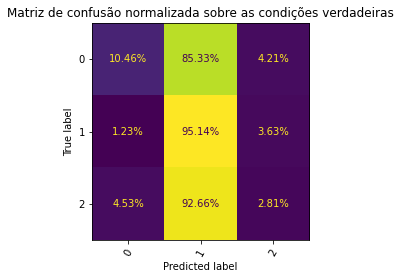

In [58]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')